In [ ]:
eta = 0.50
optimizer_lr = 1e-5 # try 1e-5 from dim=2

dim = 12
n_center = 10
l = 5

num_layers = 30
width = 512

n_max_mirror_iterations=15       # num mirror steps
n_max_iterations=6000        # max inner steps

num_samples = 10000         # number of theta generated for training
num_samples_test =  8192 # samples to estimate KL
import math
verbose = True
set_seed = 114540 # seed not used.
exp_number = 0 # [0, 1, 2, 3, 4]
pretrain_factor = 100



In [ ]:
!pip install normflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normflows: filename=normflows-1.7.3-py2.py3-none-any.whl size=87245 sha256=fbc6b8f7565ce60d8d322f3d2266758a28679241e36d5c6ecd89394f92f686b7
  Stored in directory: /root/.cache/pip/wheels/08/b1/a6/f018e29f12dc6251793263911d14764ddad0a6844f7b024007
Successfully built normflows


In [ ]:
import numpy as np
import zlib
from multipledispatch import dispatch
import torch
import random

class RandomManager:
    '''
    Manage random using crc32 checksum for seeds generating
    '''

    @staticmethod
    def _get_crc32_seed(_str):
        _bstr = str.encode(_str)
        return zlib.crc32(_bstr)

    def _make_str(self, *args):
        return '@'.join(map(str, args))

    def __init__(self, *args):
        self._str = self._make_str(*args)

    def get_seed(self, *postfixes):
        _str = self._str + self._make_str(*postfixes)
        return self._get_crc32_seed(_str)

    def seed_random(self, *postfixes):
        rnd_postfixes = ('random',) + postfixes
        random.seed(self.get_seed(*rnd_postfixes))
        return self

    def seed_torch(self, *postfixes):
        torch_postfixes = ('pytorch',) + postfixes
        torch.manual_seed(self.get_seed(*torch_postfixes))
        return self

    def seed_numpy(self, *postfixes):
        np_postfixes = ('numpy',) + postfixes
        np.random.seed(self.get_seed(*np_postfixes))
        return self

    def seed(self, *postfixes):
        return self.seed_random(*postfixes).seed_numpy(*postfixes).seed_torch(*postfixes)

def get_random_manager(*args):
    return RandomManager(*args)

In [ ]:
# Import required packages
import torch
import numpy as np
import normflows as nf
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import torch.nn.functional as F
import torch.distributions as TD
import pandas as pd
import seaborn as sb
import torch.nn as nn
import shutil
import gc
import copy
import time
from scipy.optimize import linear_sum_assignment

In [ ]:
torch.manual_seed(114514)
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

In [ ]:
def random_centers_distrib_generator(n, n_rand, target_span, std, device='cpu', dtype=torch.float32):
    centers_sample_distrib = TD.Uniform(-target_span, target_span)
    centers = centers_sample_distrib.sample((n_rand, n)).to(device, dtype)
    comp = TD.Independent(TD.Normal(centers, torch.tensor([std,]).to(device, dtype)), 1)
    mix = TD.Categorical(torch.ones(n_rand,).to(device, dtype))
    target = TD.MixtureSameFamily(mix, comp)
    return target

def random_project(input_data, p = 2, random_seed = 114514):
  import torch
# input_data n by m
# random_matrix m by p
# random_projected = 1/sqrt(p) * input_data %*% random_matrix
  torch.manual_seed(random_seed)
  m = input_data.shape[1]
  random_mx = torch.randn((m, p))
  projected = (1/torch.sqrt(torch.tensor(p)))*torch.matmul(input_data, random_mx)
  return projected

def plot_two_data(target_dist, model_transform):
  import matplotlib.pyplot as plt
  import pandas as pd
  import seaborn as sb

  df_1 = pd.DataFrame(random_project(target_dist)).astype("float")
  df_2 =  pd.DataFrame(random_project(model_transform)).astype("float")

  df_1["type"] = "target dist"
  df_2["type"] = "model transform"
  df_all = pd.concat([df_1, df_2], ignore_index=True)
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)
  sns_plot = sb.jointplot(data=df_all, x="dim_0", y="dim_1", hue="type", kind="kde")
  return sns_plot

<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


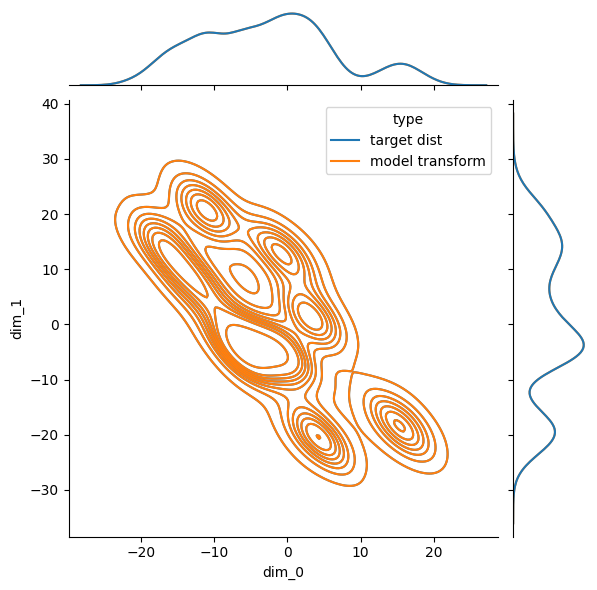

In [ ]:
r_m = get_random_manager('uran', dim, exp_number)
r_m.seed()

stationary_dist = random_centers_distrib_generator(n = dim, n_rand = n_center, target_span = l, std = 1, device=device, dtype=torch.float32)
target_samples = stationary_dist.sample((5000,))
plot_two_data(target_samples.cpu().detach(), target_samples.cpu().detach())

In [ ]:
kld1_hist = np.array([])
kld2_hist = np.array([])

trail_num = exp_number
torch.manual_seed(527)

# target_pretrain = TD.MultivariateNormal(
#     torch.zeros(dim).to(device), pretrain_factor * torch.eye(dim).to(device))
target_pretrain = TD.Uniform(-10, 10)
# Define 2D Gaussian base distribution
base = nf.distributions.DiagGaussian(dim, trainable=False)
# Define list of flows
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(dim, mode='swap'))

# for i in range(num_layers):
#     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
#     flows += [nf.flows.LULinearPermute(dim)]

# Construct flow model
model = nf.NormalizingFlow(base, flows).to(device)
optimizer1 = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

for it in tqdm(range(100)):
    optimizer1.zero_grad()

    # Get training samples
    # x = target_pretrain.sample((num_samples,)).to(device)
    x = target_pretrain.sample((num_samples, dim)).to(device)

    # Compute loss
    loss = model.forward_kld(x)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer1.step()

    if it % 100 == 99:
      clear_output(wait=True)
      print('Loss:', loss.item())


100%|██████████| 100/100 [00:30<00:00,  3.33it/s]

Loss: 38.049156188964844


<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


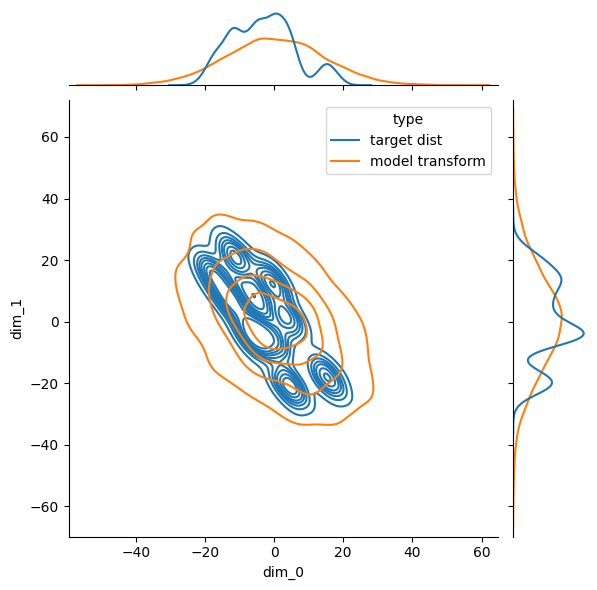

In [ ]:
target_samples = stationary_dist.sample((5000,))
model_samples, _ = model.sample(5000)
plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())

 17%|█▋        | 1000/6000 [14:42<1:21:32,  1.02it/s]

trail: 0 m step: 0 Loss: 30.0532169342041  L_n: 9.007265090942383  kld: 10.52297592163086 KLD1: 8.994460105895996 KLD2: 18.13786506652832


 33%|███▎      | 2000/6000 [29:22<1:05:11,  1.02it/s]

trail: 0 m step: 0 Loss: 27.89470100402832  L_n: 7.514753341674805  kld: 10.189973831176758 KLD1: 7.425887107849121 KLD2: 20.423444747924805


 50%|█████     | 3000/6000 [44:04<49:05,  1.02it/s]

trail: 0 m step: 0 Loss: 27.189085006713867  L_n: 7.083757400512695  kld: 10.052663803100586 KLD1: 7.037738800048828 KLD2: 19.274036407470703


 67%|██████▋   | 4000/6000 [58:44<32:35,  1.02it/s]

trail: 0 m step: 0 Loss: 26.805973052978516  L_n: 6.831733703613281  kld: 9.987119674682617 KLD1: 6.873537540435791 KLD2: 19.480077743530273


 83%|████████▎ | 5000/6000 [1:13:24<16:16,  1.02it/s]

trail: 0 m step: 0 Loss: 26.911117553710938  L_n: 6.873218536376953  kld: 10.018949508666992 KLD1: 6.715726375579834 KLD2: 18.92568016052246


100%|██████████| 6000/6000 [1:28:06<00:00,  1.13it/s]

trail: 0 m step: 0 Loss: 26.67097282409668  L_n: 6.79594612121582  kld: 9.93751335144043 KLD1: 6.810699939727783 KLD2: 18.423250198364258



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


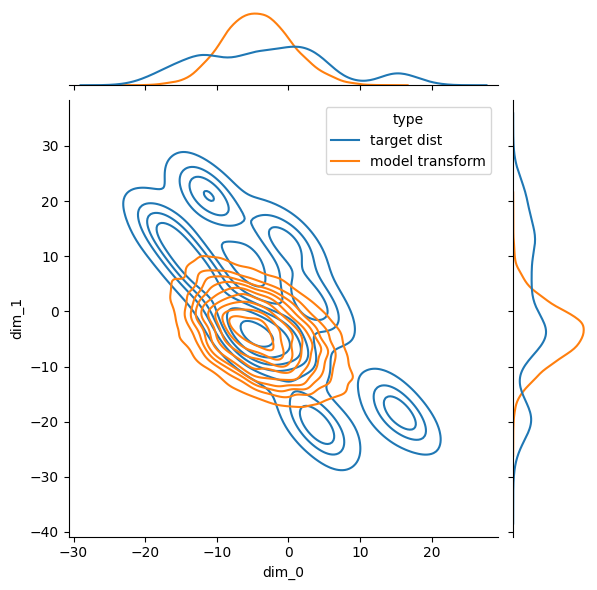

trail: 0 m step: 0 kl_test: 6.77650260925293


 17%|█▋        | 1000/6000 [14:45<1:22:09,  1.01it/s]

trail: 0 m step: 1 Loss: 4.01470947265625  L_n: 2.6702728271484375  kld: 0.6722183227539062 KLD1: 2.6607160568237305 KLD2: 30.3005313873291


 33%|███▎      | 2000/6000 [29:31<1:05:43,  1.01it/s]

trail: 0 m step: 1 Loss: 3.9910221099853516  L_n: 2.640748977661133  kld: 0.6751365661621094 KLD1: 2.5873863697052 KLD2: 30.69443702697754


 50%|█████     | 3000/6000 [44:17<49:07,  1.02it/s]

trail: 0 m step: 1 Loss: 3.9734020233154297  L_n: 2.638486862182617  kld: 0.6674575805664062 KLD1: 2.6050868034362793 KLD2: 30.42121124267578


 67%|██████▋   | 4000/6000 [59:02<32:44,  1.02it/s]

trail: 0 m step: 1 Loss: 3.935577392578125  L_n: 2.613414764404297  kld: 0.6610813140869141 KLD1: 2.6165051460266113 KLD2: 31.10260581970215


 83%|████████▎ | 5000/6000 [1:13:47<16:25,  1.01it/s]

trail: 0 m step: 1 Loss: 3.9917984008789062  L_n: 2.6114768981933594  kld: 0.6901607513427734 KLD1: 2.5542404651641846 KLD2: 30.456836700439453


100%|██████████| 6000/6000 [1:28:35<00:00,  1.13it/s]

trail: 0 m step: 1 Loss: 3.903524398803711  L_n: 2.5740184783935547  kld: 0.6647529602050781 KLD1: 2.586505889892578 KLD2: 30.252090454101562



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


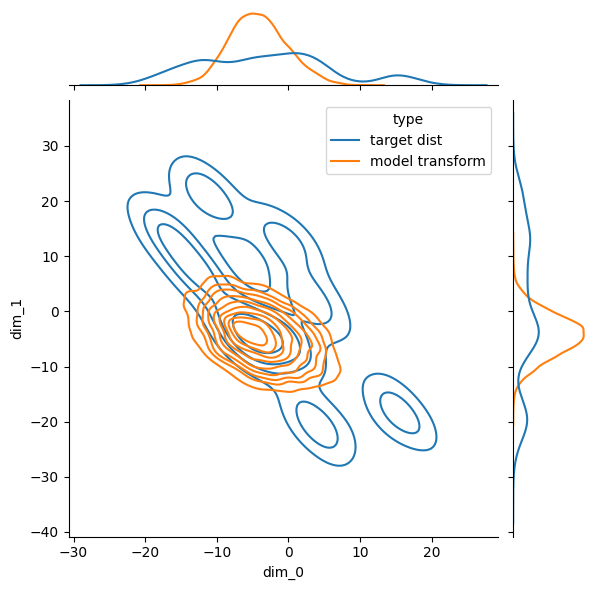

trail: 0 m step: 1 kl_test: 2.5677757263183594


 17%|█▋        | 1000/6000 [14:46<1:22:15,  1.01it/s]

trail: 0 m step: 2 Loss: 2.028411865234375  L_n: 1.7137184143066406  kld: 0.1573467254638672 KLD1: 1.7126431465148926 KLD2: 39.672325134277344


 33%|███▎      | 2000/6000 [29:32<1:05:43,  1.01it/s]

trail: 0 m step: 2 Loss: 2.031078338623047  L_n: 1.7008132934570312  kld: 0.1651325225830078 KLD1: 1.690002679824829 KLD2: 40.78626251220703


 50%|█████     | 3000/6000 [44:20<49:27,  1.01it/s]

trail: 0 m step: 2 Loss: 2.0272216796875  L_n: 1.7113189697265625  kld: 0.15795135498046875 KLD1: 1.695407748222351 KLD2: 39.333560943603516


 67%|██████▋   | 4000/6000 [59:09<32:53,  1.01it/s]

trail: 0 m step: 2 Loss: 2.006429672241211  L_n: 1.7066097259521484  kld: 0.14990997314453125 KLD1: 1.6940255165100098 KLD2: 40.235328674316406


 83%|████████▎ | 5000/6000 [1:13:58<16:29,  1.01it/s]

trail: 0 m step: 2 Loss: 2.035470962524414  L_n: 1.7017269134521484  kld: 0.1668720245361328 KLD1: 1.6656962633132935 KLD2: 39.3377799987793


100%|██████████| 6000/6000 [1:28:47<00:00,  1.13it/s]

trail: 0 m step: 2 Loss: 1.9928760528564453  L_n: 1.6713581085205078  kld: 0.16075897216796875 KLD1: 1.6813632249832153 KLD2: 38.28376388549805



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


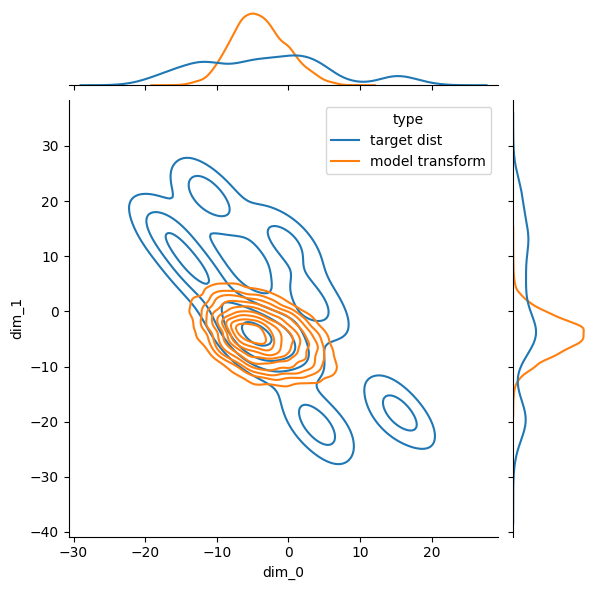

trail: 0 m step: 2 kl_test: 1.6794509887695312


 17%|█▋        | 1000/6000 [14:47<1:22:03,  1.02it/s]

trail: 0 m step: 3 Loss: 1.5201377868652344  L_n: 1.4097099304199219  kld: 0.05521392822265625 KLD1: 1.407477617263794 KLD2: 46.48975372314453


 33%|███▎      | 2000/6000 [29:34<1:05:39,  1.02it/s]

trail: 0 m step: 3 Loss: 1.5215892791748047  L_n: 1.3936824798583984  kld: 0.06395339965820312 KLD1: 1.3853213787078857 KLD2: 47.64470672607422


 50%|█████     | 3000/6000 [44:21<49:14,  1.02it/s]

trail: 0 m step: 3 Loss: 1.5194110870361328  L_n: 1.4018917083740234  kld: 0.05875968933105469 KLD1: 1.4020103216171265 KLD2: 46.37002944946289


 67%|██████▋   | 4000/6000 [59:08<32:49,  1.02it/s]

trail: 0 m step: 3 Loss: 1.514852523803711  L_n: 1.4096240997314453  kld: 0.05261421203613281 KLD1: 1.4065028429031372 KLD2: 47.69132995605469


 83%|████████▎ | 5000/6000 [1:13:55<16:26,  1.01it/s]

trail: 0 m step: 3 Loss: 1.5285301208496094  L_n: 1.4107589721679688  kld: 0.05888557434082031 KLD1: 1.385400414466858 KLD2: 48.00520324707031


100%|██████████| 6000/6000 [1:28:42<00:00,  1.13it/s]

trail: 0 m step: 3 Loss: 1.5055561065673828  L_n: 1.3925189971923828  kld: 0.0565185546875 KLD1: 1.3904577493667603 KLD2: 47.687599182128906



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


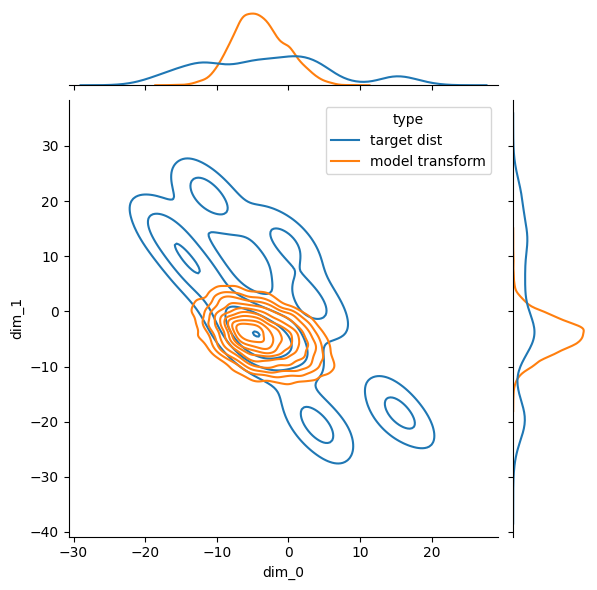

trail: 0 m step: 3 kl_test: 1.3898792266845703


 17%|█▋        | 1000/6000 [14:43<1:22:05,  1.02it/s]

trail: 0 m step: 4 Loss: 1.3553485870361328  L_n: 1.3075542449951172  kld: 0.023897171020507812 KLD1: 1.2945700883865356 KLD2: 54.77825927734375


 33%|███▎      | 2000/6000 [29:28<1:05:23,  1.02it/s]

trail: 0 m step: 4 Loss: 1.3416900634765625  L_n: 1.2795829772949219  kld: 0.031053543090820312 KLD1: 1.2727559804916382 KLD2: 56.684871673583984


 50%|█████     | 3000/6000 [44:12<49:08,  1.02it/s]

trail: 0 m step: 4 Loss: 1.3479576110839844  L_n: 1.290740966796875  kld: 0.028608322143554688 KLD1: 1.285346508026123 KLD2: 53.24647521972656


 67%|██████▋   | 4000/6000 [58:57<32:44,  1.02it/s]

trail: 0 m step: 4 Loss: 1.3457565307617188  L_n: 1.286041259765625  kld: 0.029857635498046875 KLD1: 1.2829697132110596 KLD2: 54.02793502807617


 83%|████████▎ | 5000/6000 [1:13:42<16:23,  1.02it/s]

trail: 0 m step: 4 Loss: 1.3403358459472656  L_n: 1.275421142578125  kld: 0.03245735168457031 KLD1: 1.2635923624038696 KLD2: 52.64752197265625


100%|██████████| 6000/6000 [1:28:27<00:00,  1.13it/s]

trail: 0 m step: 4 Loss: 1.3225460052490234  L_n: 1.2731494903564453  kld: 0.024698257446289062 KLD1: 1.2599126100540161 KLD2: 53.462947845458984



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


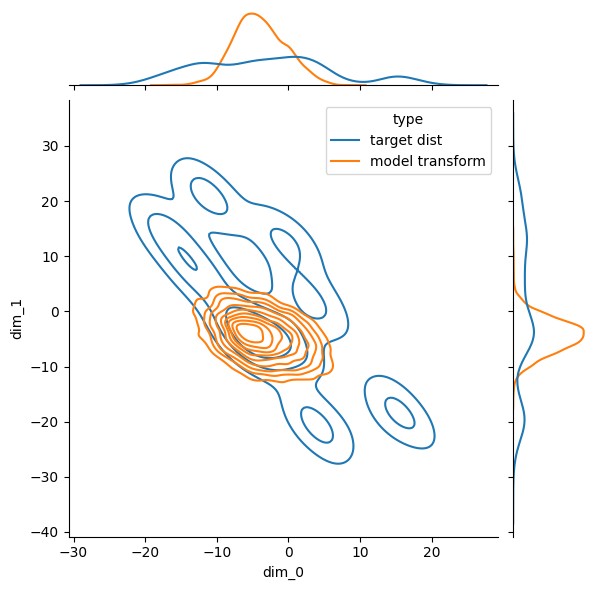

trail: 0 m step: 4 kl_test: 1.271392822265625


 17%|█▋        | 1000/6000 [14:45<1:21:59,  1.02it/s]

trail: 0 m step: 5 Loss: 1.260213851928711  L_n: 1.2133159637451172  kld: 0.023448944091796875 KLD1: 1.2170416116714478 KLD2: 58.03369903564453


 33%|███▎      | 2000/6000 [29:30<1:05:17,  1.02it/s]

trail: 0 m step: 5 Loss: 1.3143348693847656  L_n: 1.2320556640625  kld: 0.04113960266113281 KLD1: 1.2300281524658203 KLD2: 59.529998779296875


 50%|█████     | 3000/6000 [44:14<49:03,  1.02it/s]

trail: 0 m step: 5 Loss: 1.2517623901367188  L_n: 1.2111015319824219  kld: 0.020330429077148438 KLD1: 1.2084218263626099 KLD2: 55.849918365478516


 67%|██████▋   | 4000/6000 [58:57<32:41,  1.02it/s]

trail: 0 m step: 5 Loss: 1.2510147094726562  L_n: 1.2040748596191406  kld: 0.023469924926757812 KLD1: 1.2008678913116455 KLD2: 59.16362380981445


 83%|████████▎ | 5000/6000 [1:13:41<16:18,  1.02it/s]

trail: 0 m step: 5 Loss: 1.2609996795654297  L_n: 1.2135562896728516  kld: 0.023721694946289062 KLD1: 1.1895307302474976 KLD2: 58.345672607421875


100%|██████████| 6000/6000 [1:28:24<00:00,  1.13it/s]

trail: 0 m step: 5 Loss: 1.2436695098876953  L_n: 1.2045154571533203  kld: 0.0195770263671875 KLD1: 1.1997673511505127 KLD2: 56.9356803894043



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


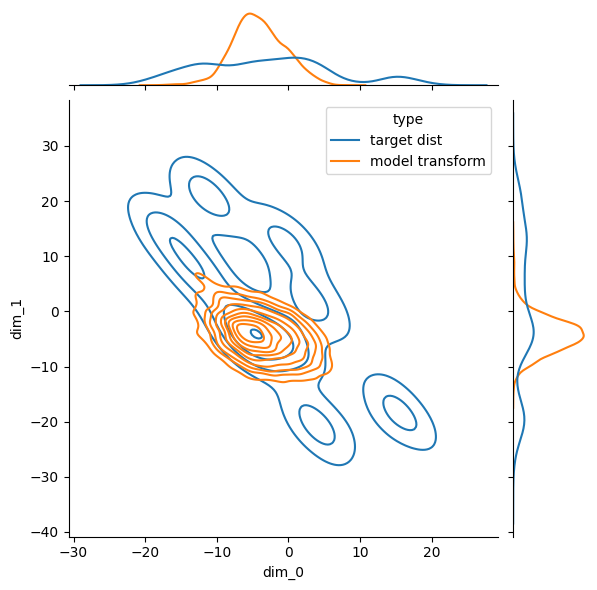

trail: 0 m step: 5 kl_test: 1.2068824768066406


 17%|█▋        | 1000/6000 [14:43<1:21:56,  1.02it/s]

trail: 0 m step: 6 Loss: 1.1917152404785156  L_n: 1.1573410034179688  kld: 0.017187118530273438 KLD1: 1.1601483821868896 KLD2: 61.87900924682617


 33%|███▎      | 2000/6000 [29:25<1:05:29,  1.02it/s]

trail: 0 m step: 6 Loss: 1.2030048370361328  L_n: 1.158376693725586  kld: 0.022314071655273438 KLD1: 1.1669142246246338 KLD2: 63.87802505493164


 50%|█████     | 3000/6000 [44:09<49:08,  1.02it/s]

trail: 0 m step: 6 Loss: 1.1988945007324219  L_n: 1.1577224731445312  kld: 0.020586013793945312 KLD1: 1.1568012237548828 KLD2: 60.568599700927734


 67%|██████▋   | 4000/6000 [58:53<32:41,  1.02it/s]

trail: 0 m step: 6 Loss: 1.1894245147705078  L_n: 1.1497669219970703  kld: 0.01982879638671875 KLD1: 1.141485571861267 KLD2: 61.301509857177734


 83%|████████▎ | 5000/6000 [1:13:37<16:22,  1.02it/s]

trail: 0 m step: 6 Loss: 1.1728534698486328  L_n: 1.1377506256103516  kld: 0.017551422119140625 KLD1: 1.1429831981658936 KLD2: 60.53264236450195


100%|██████████| 6000/6000 [1:28:21<00:00,  1.13it/s]

trail: 0 m step: 6 Loss: 1.2129898071289062  L_n: 1.1467514038085938  kld: 0.03311920166015625 KLD1: 1.152762770652771 KLD2: 61.021141052246094



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


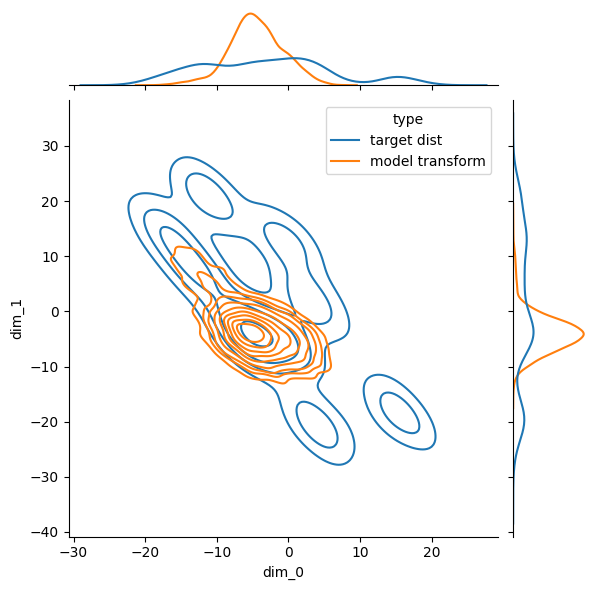

trail: 0 m step: 6 kl_test: 1.151876449584961


 17%|█▋        | 1000/6000 [14:46<1:21:57,  1.02it/s]

trail: 0 m step: 7 Loss: 1.134033203125  L_n: 1.0775184631347656  kld: 0.028257369995117188 KLD1: 1.0689181089401245 KLD2: 61.56573486328125


 33%|███▎      | 2000/6000 [29:30<1:05:31,  1.02it/s]

trail: 0 m step: 7 Loss: 1.214010238647461  L_n: 1.1456127166748047  kld: 0.034198760986328125 KLD1: 1.1425962448120117 KLD2: 70.53498840332031


 50%|█████     | 3000/6000 [44:15<49:11,  1.02it/s]

trail: 0 m step: 7 Loss: 1.14849853515625  L_n: 1.0854568481445312  kld: 0.031520843505859375 KLD1: 1.0834267139434814 KLD2: 64.02655792236328


 67%|██████▋   | 4000/6000 [59:00<32:48,  1.02it/s]

trail: 0 m step: 7 Loss: 1.1240062713623047  L_n: 1.0983562469482422  kld: 0.01282501220703125 KLD1: 1.0950340032577515 KLD2: 70.22953033447266


 83%|████████▎ | 5000/6000 [1:13:45<16:22,  1.02it/s]

trail: 0 m step: 7 Loss: 1.1224174499511719  L_n: 1.0860824584960938  kld: 0.018167495727539062 KLD1: 1.0796523094177246 KLD2: 66.90691375732422


100%|██████████| 6000/6000 [1:28:29<00:00,  1.13it/s]

trail: 0 m step: 7 Loss: 1.1189537048339844  L_n: 1.0814743041992188  kld: 0.018739700317382812 KLD1: 1.0868037939071655 KLD2: 65.40988159179688



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


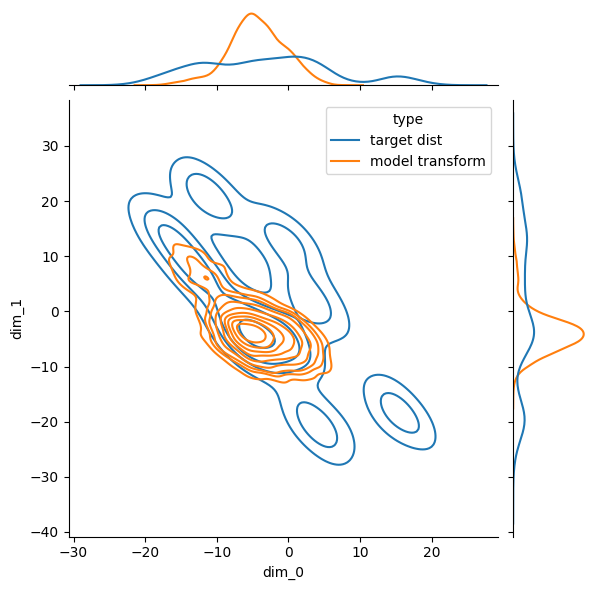

trail: 0 m step: 7 kl_test: 1.0833816528320312


 17%|█▋        | 1000/6000 [14:44<1:21:53,  1.02it/s]

trail: 0 m step: 8 Loss: 1.0844573974609375  L_n: 1.0436973571777344  kld: 0.020380020141601562 KLD1: 1.0445970296859741 KLD2: 69.39098358154297


 33%|███▎      | 2000/6000 [29:28<1:05:33,  1.02it/s]

trail: 0 m step: 8 Loss: 1.0842742919921875  L_n: 1.0530662536621094  kld: 0.015604019165039062 KLD1: 1.0420820713043213 KLD2: 73.53437042236328


 50%|█████     | 3000/6000 [44:12<49:01,  1.02it/s]

trail: 0 m step: 8 Loss: 1.1405105590820312  L_n: 1.0739173889160156  kld: 0.03329658508300781 KLD1: 1.080513596534729 KLD2: 68.76343536376953


 67%|██████▋   | 4000/6000 [58:56<32:43,  1.02it/s]

trail: 0 m step: 8 Loss: 1.0772132873535156  L_n: 1.0509529113769531  kld: 0.01313018798828125 KLD1: 1.051064133644104 KLD2: 78.27530670166016


 83%|████████▎ | 5000/6000 [1:13:41<16:23,  1.02it/s]

trail: 0 m step: 8 Loss: 1.063680648803711  L_n: 1.0415821075439453  kld: 0.011049270629882812 KLD1: 1.048256278038025 KLD2: 73.59534454345703


100%|██████████| 6000/6000 [1:28:26<00:00,  1.13it/s]

trail: 0 m step: 8 Loss: 1.0675048828125  L_n: 1.0418548583984375  kld: 0.01282501220703125 KLD1: 1.043229103088379 KLD2: 72.6126708984375



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


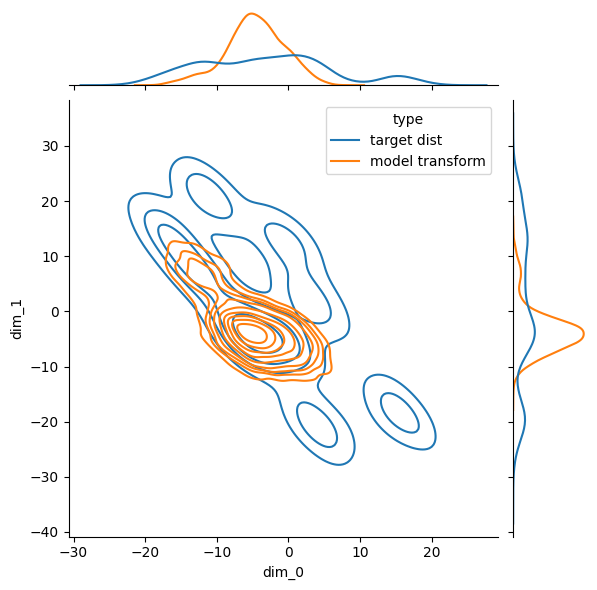

trail: 0 m step: 8 kl_test: 1.0420989990234375


 17%|█▋        | 1000/6000 [14:45<1:21:52,  1.02it/s]

trail: 0 m step: 9 Loss: 1.0700244903564453  L_n: 1.0241107940673828  kld: 0.02295684814453125 KLD1: 1.0159634351730347 KLD2: 73.62703704833984


 33%|███▎      | 2000/6000 [29:30<1:05:28,  1.02it/s]

trail: 0 m step: 9 Loss: 1.0484180450439453  L_n: 1.0339908599853516  kld: 0.007213592529296875 KLD1: 1.0388033390045166 KLD2: 78.83203125


 50%|█████     | 3000/6000 [44:15<49:14,  1.02it/s]

trail: 0 m step: 9 Loss: 1.0382747650146484  L_n: 1.0086116790771484  kld: 0.01483154296875 KLD1: 1.0106803178787231 KLD2: 74.39086151123047


 67%|██████▋   | 4000/6000 [59:00<32:43,  1.02it/s]

trail: 0 m step: 9 Loss: 1.049936294555664  L_n: 1.0263233184814453  kld: 0.011806488037109375 KLD1: 1.0177289247512817 KLD2: 78.01112365722656


 83%|████████▎ | 5000/6000 [1:13:46<16:21,  1.02it/s]

trail: 0 m step: 9 Loss: 1.033071517944336  L_n: 1.0156497955322266  kld: 0.008710861206054688 KLD1: 1.014391303062439 KLD2: 75.81281280517578


100%|██████████| 6000/6000 [1:28:31<00:00,  1.13it/s]

trail: 0 m step: 9 Loss: 1.0391902923583984  L_n: 1.011648178100586  kld: 0.01377105712890625 KLD1: 1.007662057876587 KLD2: 73.28453826904297



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


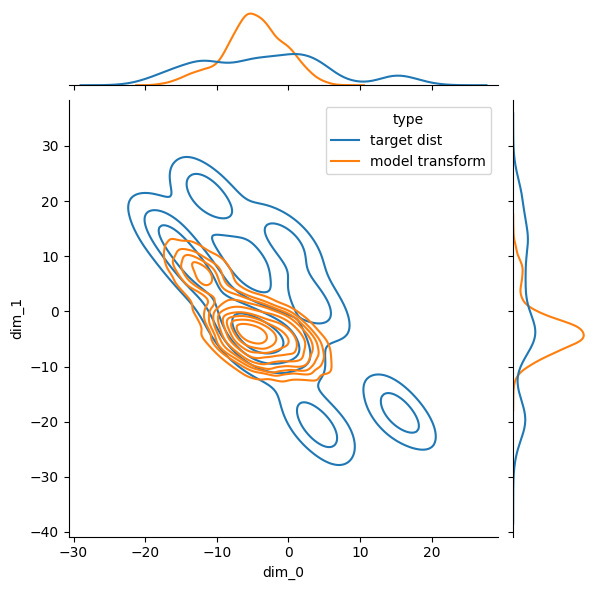

trail: 0 m step: 9 kl_test: 1.0108318328857422


 17%|█▋        | 1000/6000 [14:45<1:22:08,  1.01it/s]

trail: 0 m step: 10 Loss: 1.0384693145751953  L_n: 0.9866085052490234  kld: 0.025930404663085938 KLD1: 0.9845976233482361 KLD2: 78.57122039794922


 33%|███▎      | 2000/6000 [29:31<1:05:37,  1.02it/s]

trail: 0 m step: 10 Loss: 1.0830516815185547  L_n: 0.9906101226806641  kld: 0.04622077941894531 KLD1: 0.9783691167831421 KLD2: 78.96038818359375


 50%|█████     | 3000/6000 [44:16<49:10,  1.02it/s]

trail: 0 m step: 10 Loss: 1.0332050323486328  L_n: 0.9951763153076172  kld: 0.019014358520507812 KLD1: 0.9841222167015076 KLD2: 72.5382080078125


 67%|██████▋   | 4000/6000 [59:00<32:42,  1.02it/s]

trail: 0 m step: 10 Loss: 1.0237617492675781  L_n: 0.994049072265625  kld: 0.014856338500976562 KLD1: 0.9886893033981323 KLD2: 75.46541595458984


 83%|████████▎ | 5000/6000 [1:13:46<16:24,  1.02it/s]

trail: 0 m step: 10 Loss: 1.0097808837890625  L_n: 0.9962654113769531  kld: 0.0067577362060546875 KLD1: 1.0053859949111938 KLD2: 75.35665893554688


100%|██████████| 6000/6000 [1:28:30<00:00,  1.13it/s]

trail: 0 m step: 10 Loss: 1.0178852081298828  L_n: 0.9991626739501953  kld: 0.00936126708984375 KLD1: 0.9923811554908752 KLD2: 73.33613586425781



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


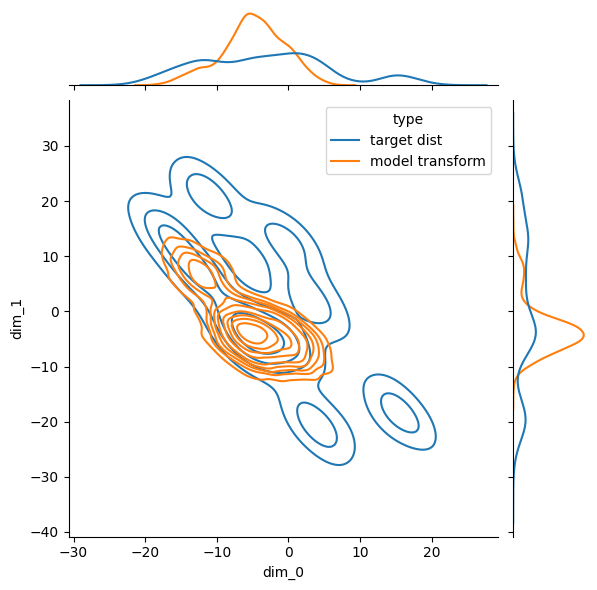

trail: 0 m step: 10 kl_test: 0.9932994842529297


 17%|█▋        | 1000/6000 [14:44<1:21:55,  1.02it/s]

trail: 0 m step: 11 Loss: 1.0563392639160156  L_n: 0.9852752685546875  kld: 0.03553199768066406 KLD1: 0.9768310189247131 KLD2: 77.2403335571289


 33%|███▎      | 2000/6000 [29:30<1:05:30,  1.02it/s]

trail: 0 m step: 11 Loss: 1.0234909057617188  L_n: 0.98114013671875  kld: 0.021175384521484375 KLD1: 0.9801915884017944 KLD2: 71.76567077636719


 50%|█████     | 3000/6000 [44:15<49:04,  1.02it/s]

trail: 0 m step: 11 Loss: 1.0283889770507812  L_n: 0.9848899841308594  kld: 0.021749496459960938 KLD1: 0.9815829992294312 KLD2: 70.71526336669922


 67%|██████▋   | 4000/6000 [58:57<32:38,  1.02it/s]

trail: 0 m step: 11 Loss: 1.0432510375976562  L_n: 0.9619483947753906  kld: 0.04065132141113281 KLD1: 0.9578990936279297 KLD2: 73.76763916015625


 83%|████████▎ | 5000/6000 [1:13:40<16:22,  1.02it/s]

trail: 0 m step: 11 Loss: 1.029144287109375  L_n: 0.9755058288574219  kld: 0.026819229125976562 KLD1: 0.9723362922668457 KLD2: 71.50676727294922


100%|██████████| 6000/6000 [1:28:26<00:00,  1.13it/s]

trail: 0 m step: 11 Loss: 1.0059967041015625  L_n: 0.9686508178710938  kld: 0.018672943115234375 KLD1: 0.965999186038971 KLD2: 68.72088623046875



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


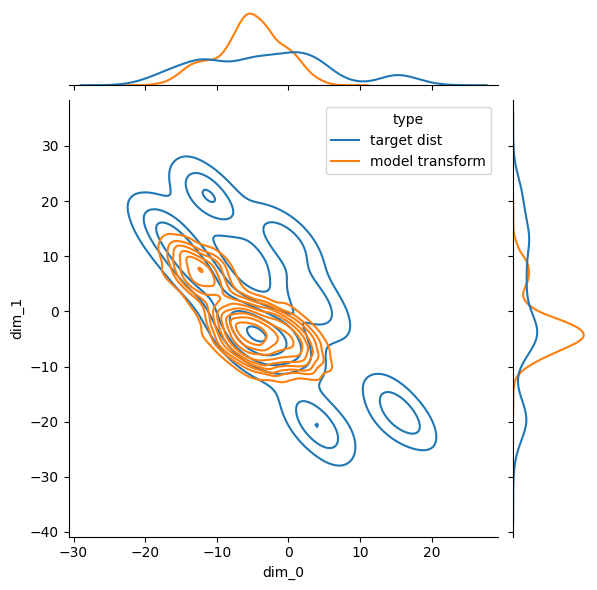

trail: 0 m step: 11 kl_test: 0.9692440032958984


 17%|█▋        | 1000/6000 [14:43<1:21:53,  1.02it/s]

trail: 0 m step: 12 Loss: 1.0534305572509766  L_n: 0.9956264495849609  kld: 0.028902053833007812 KLD1: 0.9878480434417725 KLD2: 67.40985870361328


 33%|███▎      | 2000/6000 [29:28<1:05:35,  1.02it/s]

trail: 0 m step: 12 Loss: 1.039754867553711  L_n: 1.0002880096435547  kld: 0.019733428955078125 KLD1: 0.9912695288658142 KLD2: 69.09674072265625


 50%|█████     | 3000/6000 [44:13<49:10,  1.02it/s]

trail: 0 m step: 12 Loss: 1.0365047454833984  L_n: 1.0031452178955078  kld: 0.016679763793945312 KLD1: 0.9923134446144104 KLD2: 68.67745971679688


 67%|██████▋   | 4000/6000 [58:58<32:46,  1.02it/s]

trail: 0 m step: 12 Loss: 0.9859523773193359  L_n: 0.9741268157958984  kld: 0.00591278076171875 KLD1: 0.9656816124916077 KLD2: 67.04023742675781


 83%|████████▎ | 5000/6000 [1:13:44<16:25,  1.02it/s]

trail: 0 m step: 12 Loss: 1.0003108978271484  L_n: 0.9635181427001953  kld: 0.018396377563476562 KLD1: 0.9669495820999146 KLD2: 65.63297271728516


100%|██████████| 6000/6000 [1:28:30<00:00,  1.13it/s]

trail: 0 m step: 12 Loss: 0.9819698333740234  L_n: 0.9703235626220703  kld: 0.0058231353759765625 KLD1: 0.9735773205757141 KLD2: 64.9941635131836



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


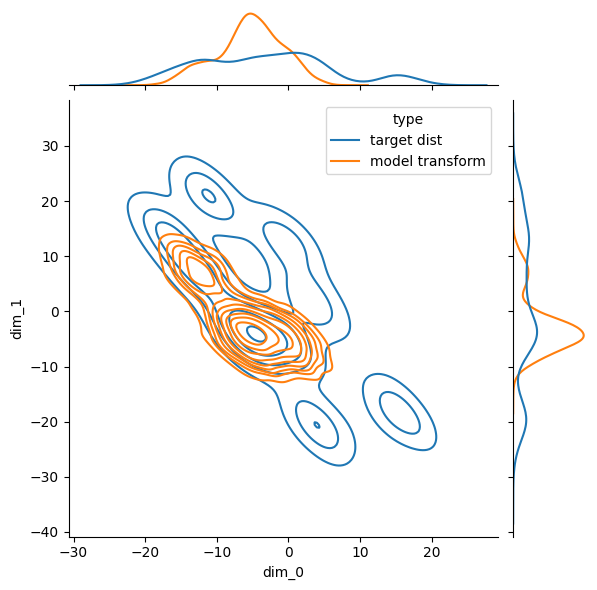

trail: 0 m step: 12 kl_test: 0.9723339080810547


 17%|█▋        | 1000/6000 [14:44<1:21:51,  1.02it/s]

trail: 0 m step: 13 Loss: 0.9971847534179688  L_n: 0.9679527282714844  kld: 0.014616012573242188 KLD1: 0.9630208015441895 KLD2: 66.01065063476562


 33%|███▎      | 2000/6000 [29:29<1:05:44,  1.01it/s]

trail: 0 m step: 13 Loss: 1.1457042694091797  L_n: 0.9868679046630859  kld: 0.07941818237304688 KLD1: 0.97977614402771 KLD2: 66.76292419433594


 50%|█████     | 3000/6000 [44:15<49:07,  1.02it/s]

trail: 0 m step: 13 Loss: 0.9909248352050781  L_n: 0.9659957885742188  kld: 0.012464523315429688 KLD1: 0.9626140594482422 KLD2: 63.831722259521484


 67%|██████▋   | 4000/6000 [59:00<32:45,  1.02it/s]

trail: 0 m step: 13 Loss: 1.0180892944335938  L_n: 0.9562110900878906  kld: 0.030939102172851562 KLD1: 0.9581876993179321 KLD2: 67.81108856201172


 83%|████████▎ | 5000/6000 [1:13:46<16:23,  1.02it/s]

trail: 0 m step: 13 Loss: 0.9755592346191406  L_n: 0.9627304077148438  kld: 0.0064144134521484375 KLD1: 0.965562641620636 KLD2: 65.5426025390625


100%|██████████| 6000/6000 [1:28:31<00:00,  1.13it/s]

trail: 0 m step: 13 Loss: 0.9747352600097656  L_n: 0.9561920166015625  kld: 0.009271621704101562 KLD1: 0.9543633460998535 KLD2: 65.67864990234375



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


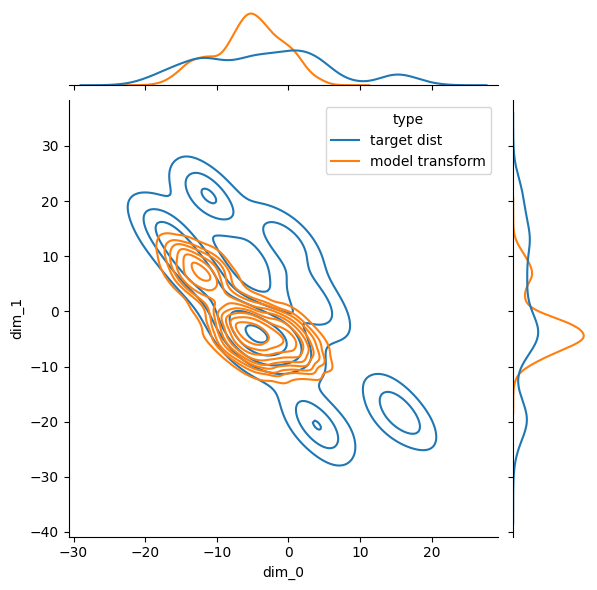

trail: 0 m step: 13 kl_test: 0.9550151824951172


 17%|█▋        | 1000/6000 [14:45<1:21:57,  1.02it/s]

trail: 0 m step: 14 Loss: 0.9855422973632812  L_n: 0.9633293151855469  kld: 0.011106491088867188 KLD1: 0.9565216302871704 KLD2: 67.62422180175781


 33%|███▎      | 2000/6000 [29:32<1:05:42,  1.01it/s]

trail: 0 m step: 14 Loss: 1.0088081359863281  L_n: 0.968505859375  kld: 0.020151138305664062 KLD1: 0.9658529758453369 KLD2: 72.93697357177734


 50%|█████     | 3000/6000 [44:18<49:15,  1.01it/s]

trail: 0 m step: 14 Loss: 1.0080833435058594  L_n: 0.9659385681152344  kld: 0.0210723876953125 KLD1: 0.9673407077789307 KLD2: 65.49422454833984


 67%|██████▋   | 4000/6000 [59:04<32:50,  1.01it/s]

trail: 0 m step: 14 Loss: 0.9854393005371094  L_n: 0.9636039733886719  kld: 0.01091766357421875 KLD1: 0.9626035690307617 KLD2: 65.39234924316406


 83%|████████▎ | 5000/6000 [1:13:51<16:22,  1.02it/s]

trail: 0 m step: 14 Loss: 0.9658432006835938  L_n: 0.9503898620605469  kld: 0.0077266693115234375 KLD1: 0.9496608376502991 KLD2: 65.34899139404297


100%|██████████| 6000/6000 [1:28:35<00:00,  1.13it/s]

trail: 0 m step: 14 Loss: 0.9801216125488281  L_n: 0.9642219543457031  kld: 0.0079498291015625 KLD1: 0.9624640345573425 KLD2: 62.878074645996094



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


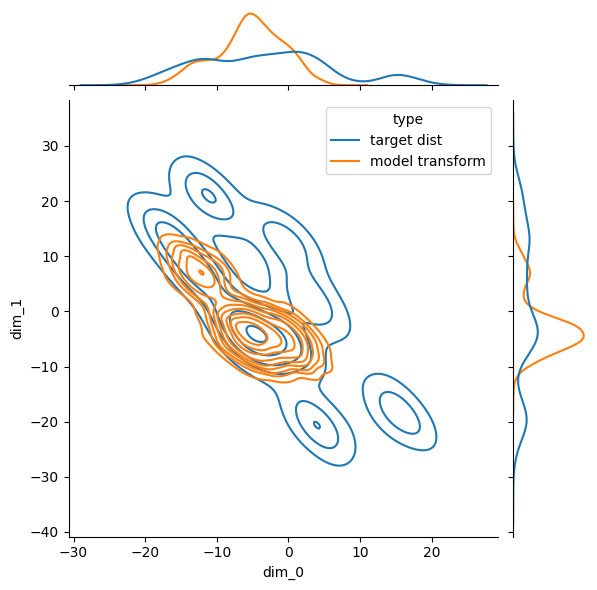

trail: 0 m step: 14 kl_test: 0.9589443206787109


In [ ]:
for mirror_itr in range(n_max_mirror_iterations):
  flows = []
  for i in range(num_layers):
      param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
      flows.append(nf.flows.AffineCouplingBlock(param_map))
      flows.append(nf.flows.Permute(dim, mode='swap'))

  # for i in range(num_layers):
  #     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
  #     flows += [nf.flows.LULinearPermute(dim)]

  model2 = nf.NormalizingFlow(base, flows, stationary_dist).to(device)
  model2.load_state_dict(model.state_dict())
  lr_decay_factor = math.floor(mirror_itr/30) # decay the lr by 1/4 for every 30 mirror steps
  optimizer_lr_input = optimizer_lr * ((1/4 )** lr_decay_factor)
  optimizer = torch.optim.Adam(model2.parameters(), lr=optimizer_lr_input, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

  input_eta = eta
  for it in tqdm(range(n_max_iterations), disable = not verbose):
    model2 = model2.train()
    optimizer.zero_grad()
    # torch.manual_seed(set_seed + trail_num)
    z = base.sample(num_samples)
    log_prob_rho_0 = base.log_prob(z)
    sampled_theta, log_det_model = model2.forward_and_log_det(z)
    log_prob_model = log_prob_rho_0 - log_det_model
    log_prob_prev = model.log_prob(sampled_theta)

    L_n_loss =  model2.reverse_kld(num_samples=num_samples)
    kld_loss = torch.mean(log_prob_model).to(torch.double) - torch.mean(log_prob_prev).to(torch.double)
    kld_loss = kld_loss if kld_loss.item() >= 0 else torch.tensor([0.0]).to(device)
    kld_loss = kld_loss if kld_loss.item() <= 500 else torch.tensor([500.0]).to(device)
    loss = L_n_loss   + (1/input_eta)*kld_loss

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      scheduler.step()


    if verbose:
      if it % 1000 == 999:
        with torch.no_grad():
          model2.eval()
          target_samples = stationary_dist.sample((num_samples,))
          temp1 = model2.log_prob(sampled_theta) - stationary_dist.log_prob(sampled_theta)
          temp2 = stationary_dist.log_prob(target_samples) - model2.log_prob(target_samples)
        kld_1 = torch.mean(temp1)
        kld_2 = torch.mean(temp2)
        print('trail:',trail_num,'m step:',mirror_itr,'Loss:', loss.item(), ' L_n:', L_n_loss.item() , ' kld:',kld_loss.item(), 'KLD1:', kld_1.item(), 'KLD2:', kld_2.item()  )

  model.load_state_dict(model2.state_dict())
  kld1_hist = np.append(kld1_hist, kld_1.to('cpu').data.numpy())
  kld2_hist = np.append(kld2_hist, kld_2.to('cpu').data.numpy())
  with torch.no_grad():
    model.eval()
    target_samples = stationary_dist.sample((5000,))
    model_samples, _ = model.sample(5000)
    kl_test = model2.reverse_kld(num_samples=num_samples_test)
    kl_test = kl_test.cpu().detach()
  plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())
  plt.show()
  print('trail:',trail_num,'m step:',mirror_itr,'kl_test:', kl_test.item()   )


<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


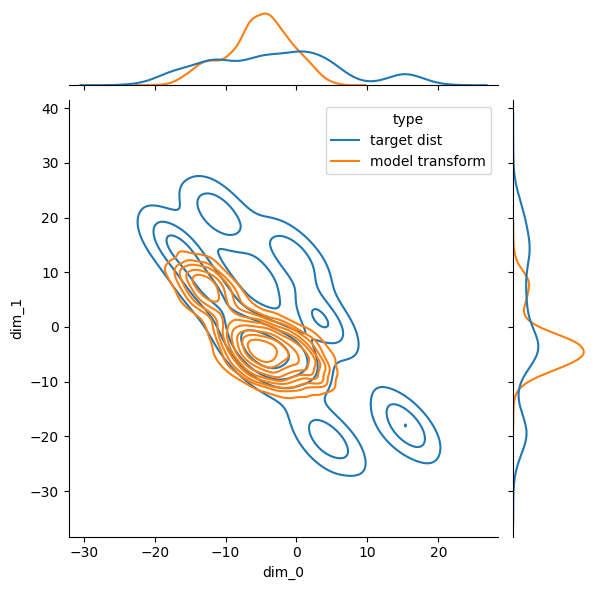

In [ ]:
target_samples = stationary_dist.sample((5000,))
model_samples, _ = model.sample(5000)
plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())